<a href="https://colab.research.google.com/github/PhaniChandraSekhar/AIML_Practice/blob/main/AIML_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Random Forest - Heart Disease Prediction**

**Category:** Supervised Learning (Classification/Regression)

**Description:**
Ensemble method that builds multiple decision trees and merges their predictions.

**Key Components:**
- Sampling: Bootstrap
- Ensemble Method: Bagging
- Voting: Majority (Classification) or Average (Regression)

**Example Application:**

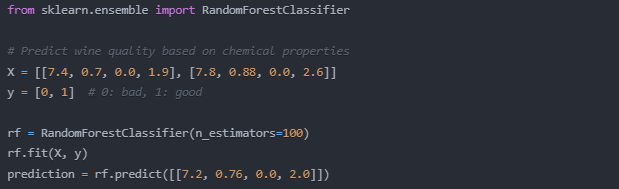



**Best Used For:**
- Feature importance ranking
- Credit card fraud detection
- Disease prediction
- Stock market analysis


**Implementation Steps include:**
**Data Analysis:**

Exploratory Data Analysis (EDA)
Feature correlation analysis
Distribution analysis
Target variable analysis


**Model Implementation:**

Hyperparameter tuning with RandomizedSearchCV
Cross-validation
Feature importance analysis
SHAP value analysis


**Evaluation Metrics:**

Classification report
Confusion matrix
ROC curve
Cross-validation scores


**Visualizations:**

Feature importance plots
SHAP summary plots
ROC curves
Distribution plots
Correlation heatmaps



**Future impprovements to do:**

Add other ensemble methods for comparison?
Include more advanced feature selection techniques?
Add more visualization types?
Implement different cross-validation strategies?
Add more detailed SHAP analysis?

In [ ]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn plotly shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import shap
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Download the dataset
!kaggle datasets download -d johnsmith88/heart-disease-dataset
!unzip heart-disease-dataset.zip

In [ ]:
class HeartDiseasePredictor:
    def __init__(self):
        """Initialize Heart Disease Predictor"""
        self.df = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.feature_importance = None
        self.predictions = None

    def load_data(self):
        """Load Heart Disease Dataset"""
        # For Colab, first upload the dataset or use these commands:
        '''
        !pip install kaggle
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !kaggle datasets download -d johnsmith88/heart-disease-dataset
        !unzip heart-disease-dataset.zip
        '''

        self.df = pd.read_csv('heart.csv')
        print("Dataset Shape:", self.df.shape)
        print("\nFeatures:", self.df.columns.tolist())
        print("\nSample Data:")
        print(self.df.head())

        return self.df

    def explore_data(self):
        """Perform exploratory data analysis"""
        # 1. Target Distribution
        plt.figure(figsize=(8, 5))
        sns.countplot(data=self.df, x='target')
        plt.title('Distribution of Heart Disease')
        plt.xlabel('Has Heart Disease')
        plt.show()

        # 2. Correlation Matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(self.df.corr(), annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.show()

        # 3. Age Distribution by Target
        plt.figure(figsize=(10, 6))
        sns.histplot(data=self.df, x='age', hue='target', multiple="stack")
        plt.title('Age Distribution by Heart Disease')
        plt.show()

        # 4. Numerical Features Distribution
        numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(numerical_features, 1):
            plt.subplot(2, 3, i)
            sns.boxplot(data=self.df, x='target', y=feature)
            plt.title(f'{feature} by Target')
        plt.tight_layout()
        plt.show()

        # 5. Categorical Features Analysis
        categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
        plt.figure(figsize=(20, 15))
        for i, feature in enumerate(categorical_features, 1):
            plt.subplot(3, 3, i)
            sns.countplot(data=self.df, x=feature, hue='target')
            plt.title(f'{feature} by Target')
        plt.tight_layout()
        plt.show()

    def preprocess_data(self):
        """Preprocess the data for modeling"""
        # Separate features and target
        self.X = self.df.drop('target', axis=1)
        self.y = self.df['target']

        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

        # Scale features
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

        return self.X_train, self.X_test, self.y_train, self.y_test

    def train_model(self):
        """Train Random Forest model with hyperparameter tuning"""
        # Define parameter grid for RandomizedSearchCV
        param_grid = {
            'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [10, 20, 30, 40, 50, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt']
        }

        # Initialize base model
        rf_base = RandomForestClassifier(random_state=42)

        # Perform RandomizedSearchCV
        rf_random = RandomizedSearchCV(
            estimator=rf_base,
            param_distributions=param_grid,
            n_iter=100,
            cv=5,
            random_state=42,
            n_jobs=-1
        )

        # Fit the random search model
        rf_random.fit(self.X_train, self.y_train)

        # Get best model
        self.model = rf_random.best_estimator_
        print("\nBest Parameters:", rf_random.best_params_)

        # Get feature importance
        self.feature_importance = pd.DataFrame({
            'feature': self.df.drop('target', axis=1).columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        return self.model

    def evaluate_model(self):
        """Evaluate model performance"""
        # Make predictions
        self.predictions = self.model.predict(self.X_test)

        # 1. Print Classification Report
        print("\nClassification Report:")
        print(classification_report(self.y_test, self.predictions))

        # 2. Plot Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(self.y_test, self.predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # 3. ROC Curve
        y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

        # 4. Feature Importance Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(data=self.feature_importance, x='importance', y='feature')
        plt.title('Feature Importance')
        plt.show()

        # 5. Cross-validation scores
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5)
        print("\nCross-validation scores:", cv_scores)
        print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

    def analyze_feature_impact(self):
        """Analyze feature impact using SHAP values"""
        # Calculate SHAP values
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.X_test)

        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values[1], self.X_test,
                         feature_names=self.df.drop('target', axis=1).columns,
                         show=False)
        plt.title('SHAP Summary Plot')
        plt.tight_layout()
        plt.show()

        # Feature interaction plot
        plt.figure(figsize=(10, 8))
        shap.dependence_plot(
            "age",
            shap_values[1],
            self.X_test,
            feature_names=self.df.drop('target', axis=1).columns,
            show=False
        )
        plt.title('SHAP Interaction Plot: Age')
        plt.tight_layout()
        plt.show()

    def make_prediction(self, patient_data):
        """Make prediction for new patient data"""
        # Ensure data is in correct format
        if isinstance(patient_data, dict):
            patient_data = pd.DataFrame([patient_data])

        # Scale the data
        scaler = StandardScaler()
        patient_data_scaled = scaler.fit_transform(patient_data)

        # Make prediction
        prediction = self.model.predict(patient_data_scaled)
        prediction_proba = self.model.predict_proba(patient_data_scaled)

        return {
            'prediction': prediction[0],
            'probability': prediction_proba[0][1]
        }


In [ ]:
def main():
    # Create instance of HeartDiseasePredictor
    predictor = HeartDiseasePredictor()

    # Step 1: Load data
    print("Step 1: Loading data...")
    predictor.load_data()

    # Step 2: Explore data
    print("\nStep 2: Exploring data...")
    predictor.explore_data()

    # Step 3: Preprocess data
    print("\nStep 3: Preprocessing data...")
    predictor.preprocess_data()

    # Step 4: Train model
    print("\nStep 4: Training model...")
    predictor.train_model()

    # Step 5: Evaluate model
    print("\nStep 5: Evaluating model...")
    predictor.evaluate_model()

    # Step 6: Analyze feature impact
    print("\nStep 6: Analyzing feature impact...")
    predictor.analyze_feature_impact()

    # Example prediction
    print("\nStep 7: Example prediction...")
    sample_patient = {
        'age': 65,
        'sex': 1,
        'cp': 0,
        'trestbps': 140,
        'chol': 250,
        'fbs': 0,
        'restecg': 0,
        'thalach': 150,
        'exang': 0,
        'oldpeak': 1.5,
        'slope': 1,
        'ca': 0,
        'thal': 2
    }

    result = predictor.make_prediction(sample_patient)
    print("\nPrediction for sample patient:")
    print(f"Heart Disease: {'Yes' if result['prediction'] == 1 else 'No'}")
    print(f"Probability: {result['probability']:.2f}")

if __name__ == "__main__":
    main()